In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amarhamouma","key":"3c2351ea67223cf466bcfac2419b0568"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

In [3]:
!kaggle datasets download -d grouplens/movielens-20m-dataset

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
100% 195M/195M [00:10<00:00, 22.5MB/s]
100% 195M/195M [00:10<00:00, 19.5MB/s]


In [4]:
!unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bars

In [7]:
def load_data(ratings_file, movies_file, min_ratings=100):
    """
    Load and preprocess the dataset.
    Args:
        ratings_file (str): Path to the ratings file (e.g., rating.csv).
        movies_file (str): Path to the movies metadata file (e.g., movies.csv).
        min_ratings (int): Minimum number of ratings for a movie to be included.
    Returns:
        pd.DataFrame: Preprocessed reward history.
        pd.DataFrame: Movies metadata.
    """
    # Load ratings and movies metadata
    rewards = pd.read_csv(ratings_file)
    movies = pd.read_csv(movies_file)

    # Convert ratings to binary (liked or not liked)

    rewards["liked"] = (rewards["rating"] >= 4).astype(int)

    # Filter movies with at least min_ratings
    movie_rating_counts = rewards.groupby("movieId")["liked"].count()
    #print(f"movie_rating_counts ==== {movie_rating_counts}")
    valid_movies = movie_rating_counts[movie_rating_counts >= min_ratings].index

    rewards = rewards[rewards["movieId"].isin(valid_movies)]

    return rewards[:2000], movies

In [15]:
import numpy as np
import pandas as pd

def thompson_sampling_step(alphas, betas, epsilon, movies_ids, users, rewards, movie_col_name, userr_col_name, reward_col_name):
    """
    Perform one step of Thompson Sampling.

    Args:
        alphas (np.array): Alpha parameters for each item.
        betas (np.array): Beta parameters for each item.
        epsilon (float): Current exploration rate.
        movies_ids (np.array): List of movie IDs.
        users (np.array): List of user IDs.
        rewards (pd.DataFrame): Historical data containing user-movie interactions and rewards.
        movie_col_name (str): Column name for movies_ids (e.g., movies).
        userr_col_name (str): Column name for users (e.g., users).
        reward_col_name (str): Column name for rewards (e.g., liked or not).

    Returns:
        int: Selected item index.
        int: Observed reward.
    """
    while True:
        # Choose a random user
        user_id = np.random.choice(users)

        # Select an item to offer the user
        if np.random.random() < epsilon:
            movie_idx = np.random.choice(len(movies_ids))  # Explore: choose a random item
        else:
            # Exploit: choose the item with the highest sampled mean
            samples = np.random.beta(alphas, betas)
            movie_idx = np.argmax(samples)

        movie_id = movies_ids[movie_idx]

        # Check if the pair exists in the historical data
        reward = rewards[
            (rewards[movie_col_name] == movie_id) &
            (rewards[userr_col_name] == user_id)
        ][reward_col_name]

        if not reward.empty:
            return movie_idx, reward.iloc[0]

In [16]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def run_simulation(n_users, rewards, movies, movie_col_name, userr_col_name, reward_col_name, n_iterations=1, epsilon=0.5, decay_rate=0.95):
    """
    Run the Thompson Sampling simulation, limiting to 3000 films.

    Args:
        n_users (int): Number of users to simulate per iteration.
        rewards (pd.DataFrame): Historical data containing user-item interactions and rewards.
        movies (pd.DataFrame): Movie metadata containing movieId and title.
        movie_col_name (str): Column name for movies_ids (e.g., movies).
        userr_col_name (str): Column name for users (e.g., users).
        reward_col_name (str): Column name for rewards (e.g., liked or not).
        n_iterations (int): Number of iterations to average over.
        epsilon (float): Initial exploration rate.
        decay_rate (float): Decay rate for exploration.

    Returns:
        pd.DataFrame: Results of the simulation.
    """
    # Create a mapping from movieId to movie title
    movie_name_mapping = dict(zip(movies["movieId"], movies["title"]))

    # Get unique movies_ids and users
    movies_ids = rewards[movie_col_name].unique()
    users = rewards[userr_col_name].unique()

    # Initialize results storage
    all_results = []

    # Run simulations
    for iteration in tqdm(range(n_iterations), desc="Iterations"):
        # Reset algorithm state
        alphas = np.ones(len(movies_ids))  # Success counts for each item
        betas = np.ones(len(movies_ids))   # Failure counts for each item
        epsilon_current = epsilon  # Current exploration rate

        # Initialize metrics
        cumulative_regret = 0

        # Simulate users
        for user in range(n_users):
            # Perform one step of Thompson Sampling
            movie_idx, reward_value = thompson_sampling_step(
                alphas, betas, epsilon_current, movies_ids, users, rewards,
                movie_col_name, userr_col_name, reward_col_name
            )

            # Update algorithm state
            if reward_value == 1:
                alphas[movie_idx] += 1
            else:
                betas[movie_idx] += 1

            # Decay the exploration rate
            epsilon_current *= decay_rate

            # Calculate cumulative regret
            optimal_reward = 1  # Assume the best possible reward is 1 (liked)
            regret = optimal_reward - reward_value
            cumulative_regret += regret

            # Get the movie title using the movieId
            movie_id = movies_ids[movie_idx]
            movie_title = movie_name_mapping.get(movie_id, "Unknown Movie")

            # Store results
            result = {
                'iteration': iteration,
                'user': user,
                'movie_id': movie_id,
                'movie_title': movie_title,  # Include movie title in results
                'user_id': np.random.choice(users),  # Random user for this step
                'reward': reward_value,
                'cumulative_regret': cumulative_regret,
                'alpha': alphas[movie_idx],  # Include alpha in results
                'beta': betas[movie_idx]    # Include beta in results
            }
            all_results.append(result)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

In [17]:
def validate_results(results_df, rewards):
    """
    Validate the results by comparing posterior means with true reward probabilities.
    Args:
        results_df (pd.DataFrame): Results of the simulation.
        rewards (pd.DataFrame): Historical data containing user-item interactions and rewards.
    """
    # Calculate true reward probabilities for each movie
    true_reward_probs = rewards.groupby("movieId")["liked"].mean()

    # Calculate posterior means from the results
    results_df["posterior_mean"] = results_df["alpha"] / (results_df["alpha"] + results_df["beta"])

    # Compare with the true reward probabilities
    comparison = results_df.groupby("movie_id").agg({
        "posterior_mean": "mean",
        "movie_title": "first"  # Include movie title for clarity
    }).join(true_reward_probs.rename("true_probability"), on="movie_id")

    # Print comparison
    print("Comparison of Posterior Means and True Probabilities:")
    print(comparison.head(10))

In [18]:
def plot_results(results_df):
    """
    Plot the cumulative regret over time.
    Args:
        results_df (pd.DataFrame): Results of the simulation.
    """
    # Plot cumulative regret averaged over iterations
    avg_regret = results_df.groupby("user")["cumulative_regret"].mean()
    plt.figure(figsize=(8, 6))
    plt.plot(avg_regret.index, avg_regret.values, label="Cumulative Regret")
    plt.title("Thompson Sampling with Dataset (20,000 Users, 20 Iterations)")
    plt.xlabel("Number of iterations")
    plt.ylabel("Cumulative Regret")
    plt.legend()
    plt.show()

Iterations: 100%|██████████| 20/20 [07:39<00:00, 22.96s/it]


Comparison of Posterior Means and True Probabilities:
          posterior_mean                         movie_title  true_probability
movie_id                                                                      
1               0.852047                    Toy Story (1995)          0.888889
2               0.333333                      Jumanji (1995)          0.000000
3               0.454000             Grumpier Old Men (1995)          0.400000
5               0.333333  Father of the Bride Part II (1995)          0.000000
6               0.434000                         Heat (1995)          0.200000
7               0.501111                      Sabrina (1995)          0.250000
10              0.598413                    GoldenEye (1995)          0.400000
11              0.808832      American President, The (1995)          0.800000
14              0.333333                        Nixon (1995)          0.000000
15              0.333333             Cutthroat Island (1995)          0.00000

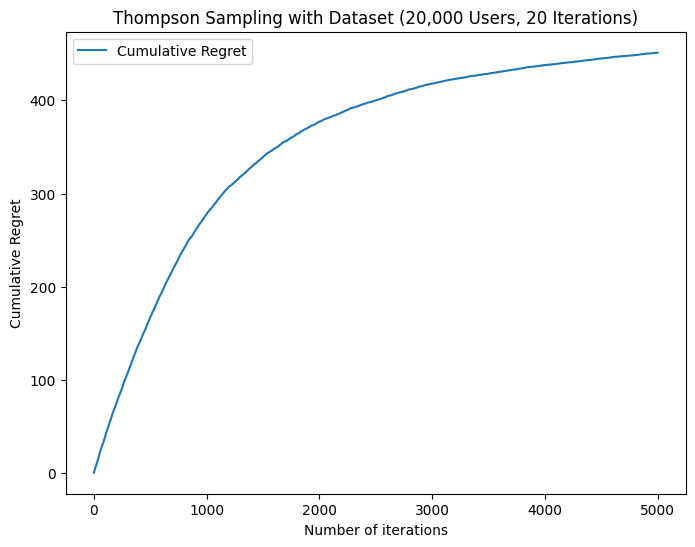

In [19]:
# Main function to run Thompson Sampling on MovieLens
if __name__ == "__main__":
    # Load and preprocess the dataset
    rewards, movies = load_data("rating.csv", "movie.csv", min_ratings=50)
    #print(rewards.head())
    # Run the simulation
    n_users = 5000  # Number of users per iteration
    n_iterations = 20  # Number of iterations
    results_df = run_simulation(
        n_users=n_users,
        rewards=rewards,
        movies=movies,
        movie_col_name="movieId",
        userr_col_name="userId",
        reward_col_name="liked",
        n_iterations=n_iterations,
        epsilon=0.5,  # Initial exploration rate
        decay_rate=0.95  # Decay rate for exploration
    )

    # Save results to disk
    results_df.to_csv("simulation_results.csv", index=False)

    # Validate the results
    validate_results(results_df, rewards)

    # Plot the results
    plot_results(results_df)